# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться _определять рыночную стоимость объектов недвижимости_.

🎯 _Задача — установить параметры_. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных:
* первые вписаны пользователем
* вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy

df = pd.read_csv('data.csv', sep='\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


## Шаг 2. Предобработка данных

* определите и изучите пропущенные значения:
  * для некоторых пропущенных значений можно предположить логичную замену.
    Например, если человек не указал число балконов — скорее всего, их нет.
    Такие пропуски правильно заменить на 0. Для других типов данных нет подходящего значения на замену.
    В этом случае правильно оставить эти значения пустыми.
    Отсутствие значения — тоже важный сигнал, который не нужно прятать;
  * заполните пропуски, где это уместно. Опишите, почему вы решили заполнить пропуски именно в этих столбцах и как выбрали значения;
  * укажите причины, которые могли привести к пропускам в данных.

* приведите данные к нужным типам:
  * поясните, в каких столбцах нужно изменить тип данных и почему.

In [2]:
df.count()

total_images            23699
last_price              23699
total_area              23699
first_day_exposition    23699
rooms                   23699
ceiling_height          14504
floors_total            23613
living_area             21796
floor                   23699
is_apartment             2775
studio                  23699
open_plan               23699
kitchen_area            21421
balcony                 12180
locality_name           23650
airports_nearest        18157
cityCenters_nearest     18180
parks_around3000        18181
parks_nearest            8079
ponds_around3000        18181
ponds_nearest            9110
days_exposition         20518
dtype: int64

In [3]:
# есть выбросы, поэтому нужно либо их убрать и заполнить пропуски средним,
# либо заполнить медианой, но это должно сместить выборку
df.ceiling_height.fillna(df.ceiling_height.median(), inplace=True)

df[df.floors_total.isna()] = df.floors_total.mean()
df[df.floors_total < df.floor].floors_total = df.floor

# можно ещё на группы разбить по площади
living_to_total_ratio = (df.living_area / df.total_area).mean()
df.living_area.fillna(df.total_area * living_to_total_ratio, inplace=True)

df.is_apartment.fillna(False, inplace=True)

kitchen_to_total_ratio = (df.kitchen_area / df.total_area).mean()
df.kitchen_area.fillna(df.total_area * kitchen_to_total_ratio, inplace=True)

df.balcony.fillna(0, inplace=True)

df.locality_name.fillna('empty', inplace=True)

df.days_exposition.fillna(df.days_exposition.mean(), inplace=True)

In [4]:
df.dtypes

total_images            float64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                   float64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                   float64
is_apartment             object
studio                   object
open_plan                object
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

In [5]:
df.days_exposition = df.days_exposition.astype('int')
df.kitchen_area = df.kitchen_area.astype('int')
df.floor = df.floor.astype('int')
df.living_area = df.living_area.astype('int')
df.floors_total = df.floors_total.astype('int')
df.ceiling_height = df.ceiling_height.astype('int')
df.rooms = df.rooms.astype('int')
df.total_images = df.total_images.astype('int')
df.last_price = df.last_price.astype('int')
df.total_area = df.total_area.astype('int')
df.first_day_exposition = df.first_day_exposition.astype('datetime64[D]')

## Шаг 3. Посчитайте и добавьте в таблицу

* цену квадратного метра;
* день недели, месяц и год публикации объявления;
* этаж квартиры; варианты — первый, последний, другой;
* соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [6]:
df['price_per_sq'] = df.last_price / df.total_area

df['day_exposition'] = df['first_day_exposition'].dt.dayofweek
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

df.loc[df.floor == 1, 'floor_name'] = 'первый'
df.loc[df.floor == df.floors_total, 'floor_name'] = 'последний'
df.loc[df.floor_name.isna(), 'floor_name'] = 'другой'

df['living_to_total_area_ratio'] = df.living_area / df.total_area
df['kitchen_to_total_area_ratio'] = df.living_area / df.total_area

## Шаг 4. Проведите исследовательский анализ данных и выполните инструкции

* Изучите следующие параметры: площадь, цена, число комнат, высота потолков.
  Постройте гистограммы для каждого параметра.

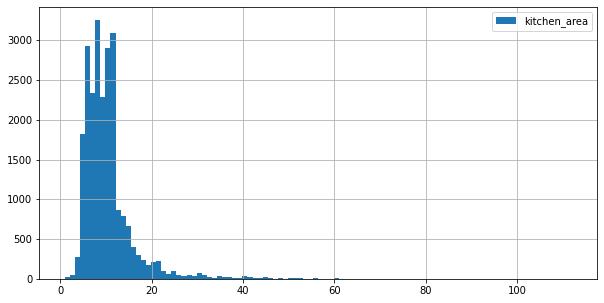

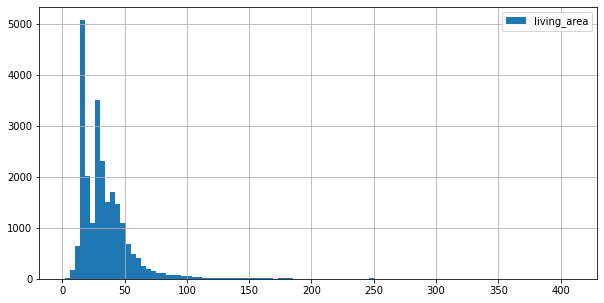

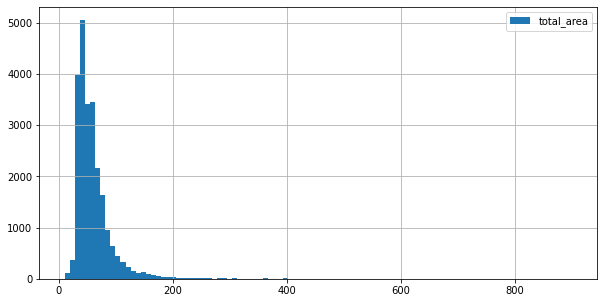

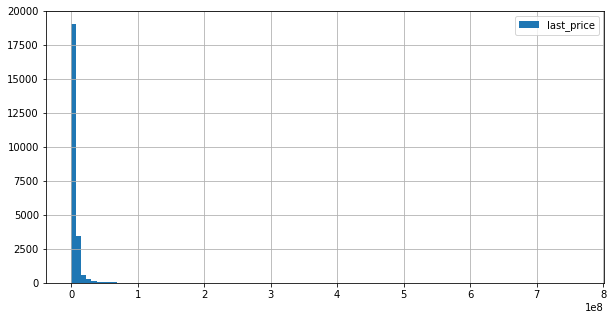

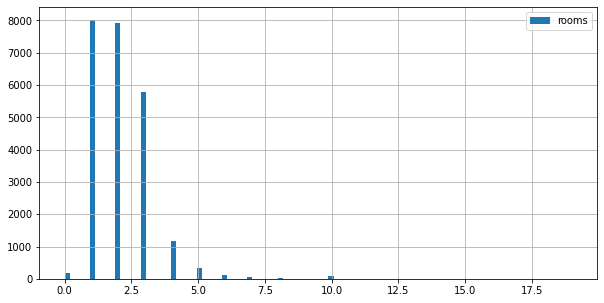

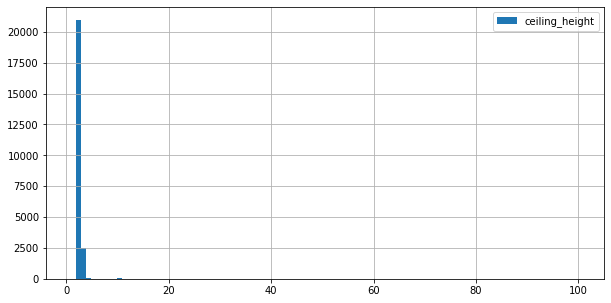

In [7]:
for feat in ['kitchen_area', 'living_area', 'total_area', 'last_price', 'rooms', 'ceiling_height']:
    df[feat].hist(legend=feat, bins=100, figsize=(10, 5))
    plt.show()

* Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану.
  Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

<AxesSubplot:>

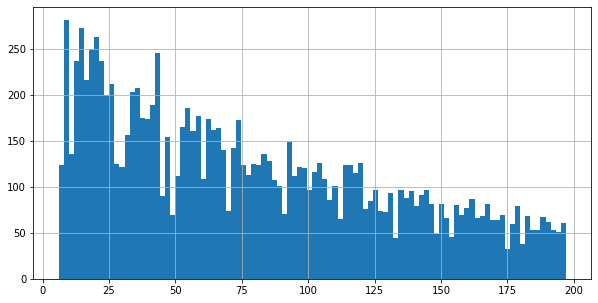

In [21]:
# наиболее часто объявления закрываются через 180, 45, 60, 7, 10, 30 дней, это просто левые объявы,
# либо ограничения сервиса
df[(df.days_exposition > 5) &
   (df.days_exposition < 198) &
   ~(df.days_exposition.isin([180, 45, 60, 7, 30, 10, 90]))].days_exposition.hist(bins=100, figsize=(10, 5))

In [22]:
df.days_exposition.describe()

count    23699.000000
mean       180.146293
std        204.284724
min          1.000000
25%         45.000000
50%        123.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

* Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

In [36]:
df = df[df.last_price > 100000]
df = df[df.ceiling_height < 10]

* Какие факторы больше всего влияют на стоимость квартиры?
  Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра.
  Также изучите зависимость от даты размещения: дня недели, месяца и года.

KeyError: "None of [Int64Index([13000000,  3350000,  5196000, 64900000, 10000000,  2890000,\n             3700000,  7915000,  2900000,  5400000,\n            ...\n             3550000,  5500000,  9470000,  1350000,  4600000,  9700000,\n             3100000,  2500000, 11475000,  1350000],\n           dtype='int64', length=23587)] are in the [columns]"

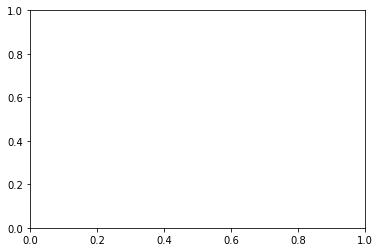

In [38]:
df.plot(kind='scatter', y=df.total_area, x=df.last_price)
